# Image Classification - Fashion MNIST
So in the previous lesson we learned about creating multi-layer networks and how that can improve the learning.

In this workbook we will do the same but with a different image data set call __Fashion-MNIST__.

This is a set of different images of Fashion items across 10 different classes (shoes, boots, shirts, dresses etc.). This dataset is harder to solve than the standard MNIST dataset due to the similarity and complexity of the image content.

# Importing some packages
We are using the Python programming language and a set of Machine Learning packages - Importing packages for use is a common task. For this workshop you don't really need to pay that much attention to this step (but you do need to execute the cell) since we are focusing on building models. However the following is a description of what this cell does that you can read if you are interested.

### Description of imports (Optional)
You don't need to worry about this code as this is not the focus on the workshop but if you are interested in what this next cell does, here is an explaination.

|Statement|Meaning|
|---|---|
|__import tensorflow as tf__ |Tensorflow (from Google) is our main machine learning library and we performs all of the various calculations for us and so hides much of the detailed complexity in Machine Learning. This _import_ statement makes the power of TensorFlow available to us and for convience we will refer to it as __tf__ |
|__from tensorflow import keras__ |Tensorflow is quite a low level machine learning library which, while powerful and flexible can be confusing so instead we use another higher level framework called Keras to make our machine learning models more readable and easier to build and test. This _import_ statement makes the Keras framework available to us.|
|__import numpy as np__ |Numpy is a Python library for scientific computing and is commonly used for machine learning. This _import_ statement makes the Keras framework available to us.|
|__import matplotlib.pyplot as plt__ |To visualise what is happening in our network we will use a set of graphs and MatPlotLib is the standard Python library for producing Graphs so we __import__ this to enable us to make pretty graphs.|
|__%matplotlib inline__| this is a Jupyter Notebook __magic__ commmand that tells the workbook to produce any graphs as part of the workbook and not as pop-up window.|

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
%matplotlib inline

## Helper functions
The following cell contains a set of helper functions that makes our models a little clearer. We will not be going through these functions (since they require Python knowlege) so just make sure you have run this cell.

In [2]:
def showSampleImages(image_data, image_labels, class_labels):
    plt.figure(figsize=(10,10))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(image_data[i], cmap=plt.cm.binary)
        plt.xlabel(class_labels[image_labels[i]])
    plt.show()

def printSampleCnnIncorrectImages(source_data, image_labels, class_names, model):
  incorrects = np.nonzero(model.predict_classes(source_data).reshape((-1,)) != image_labels)
  
  plt.figure(figsize=(10,10))
  max_items = 25 if len(incorrects[0]) > 25 else len(incorrects[0])
  
  for i in range(max_items):
    incorrect_image_index = incorrects[0][i]
    incorrect_image_data = np.array([source_data[incorrect_image_index]])
    expected_class = class_names[image_labels[incorrect_image_index]]
    preds = model.predict_classes(incorrect_image_data)    
    predicted_class = class_names[model.predict_classes(incorrect_image_data)[0]]
    errorTitle = "Expected class: '%s'\nPredicted class: '%s'"%(expected_class, predicted_class)

    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.tight_layout()
    #plt.imshow(image_data[incorrect_image_index], cmap=plt.cm.binary)
    plt.imshow(source_data[incorrect_image_index].reshape(28,28), cmap=plt.cm.binary)
    plt.xlabel(errorTitle)
  plt.show()

def displayLossAndAccuracy(history):
  plt.plot(history.history['loss'], color='red', label='Loss')
  plt.plot(history.history['acc'], color='blue', label='Accuracy')
  plt.legend()
  plt.grid(b=True, which='major', color='#666666', linestyle='-')
  plt.show()

def printSampleIncorrectImages(image_data, image_labels, class_names, model):
    incorrects = np.nonzero(model.predict_classes(image_data).reshape((-1,)) != image_labels)
    
    plt.figure(figsize=(10,10))
    max_items = 25 if len(incorrects[0]) > 25 else len(incorrects[0])
    for i in range(max_items):
        incorrect_image_index = incorrects[0][i]
        incorrect_image_data = np.array([image_data[incorrect_image_index]])
        expected_class = class_names[image_labels[incorrect_image_index]]
        predicted_class = class_names[model.predict_classes(incorrect_image_data)[0]]
        errorTitle = "Expected class: '%s'\nPredicted class: '%s'"%(expected_class, predicted_class)
    
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.tight_layout()
        plt.imshow(image_data[incorrect_image_index], cmap=plt.cm.binary)
        plt.xlabel(errorTitle)
    plt.show()

def displayConfusionMatrix(expected, predicted):
  import seaborn as sn
  from sklearn.metrics import confusion_matrix

  confusion_matrix = confusion_matrix(y_true = expected, y_pred = predicted)
  plt.figure(figsize=(12,8))
  ax = plt.subplot()
  sn.heatmap(confusion_matrix, annot=True, ax = ax)
  ax.set_xlabel('Predicted labels');
  ax.set_ylabel('Actual labels'); 
  ax.set_title('Confusion Matrix'); 

  plt.show()



def displayLayerActivations(cnn_model, image):
  import numpy as np
  from tensorflow.keras.preprocessing.image import img_to_array, load_img

  # Let's define a new Model that will take an image as input, and will output
  # intermediate representations for all layers in the previous model after
  # the first.
  successive_outputs = [layer.output for layer in cnn_model.layers[1:]]
  #visualization_model = Model(img_input, successive_outputs)
  visualization_model = tf.keras.models.Model(inputs = cnn_model.input,
                                              outputs = successive_outputs)
  
  # Let's run our image through our network, thus obtaining all
  # intermediate representations for this image.
  image = image.reshape(1,28,28,1)
  successive_feature_maps = visualization_model.predict(image)

  # These are the names of the layers, so can have them as part of our plot
  layer_names = [layer.name for layer in model.layers]

  # Now let's display our representations
  for layer_name, feature_map in zip(layer_names, successive_feature_maps):
    if len(feature_map.shape) == 4:
      # Just do this for the conv / maxpool layers, not the fully-connected layers
      n_features = feature_map.shape[-1]  # number of features in feature map
      # The feature map has shape (1, size, size, n_features)
      size = feature_map.shape[1]
      # We will tile our images in this matrix
      display_grid = np.zeros((size, size * n_features))
      for i in range(n_features):
        # Postprocess the feature to make it visually palatable
        image = feature_map[0, :, :, i]
        image -= image.mean()
        image /= image.std()
        image *= 64
        image += 128
        image = np.clip(image, 0, 255).astype('uint8')
        # We'll tile each filter into this big horizontal grid
        display_grid[:, i * size : (i + 1) * size] = image 
      # Display the grid
      scale = 20. / n_features
      plt.figure(figsize=(scale * n_features, scale))
      plt.title(layer_name)
      plt.grid(False)
      #plt.imshow(display_grid, aspect='auto', cmap='viridis')
      plt.imshow(display_grid, aspect='auto', cmap=plt.cm.binary)
      

## The Fashion MNIST dataset
The Fashion MNIST dataset is another one of the standard datasets for learning Machine Learning. It contains a set of labelled images across 10 different classes. The images are small (28x28) and greyscale but the are noticably different and most are easy to recognise by a human.

As a standard dataset, it comes with Keras and is already split into a Training and Test Set for us.

It is a harder problem to solve than the handwritten digits since some classes of images are share similarities. For example, a Shirt and a Pullover have similar shapes.

Let's load the dataset and look at some of the images.

In [3]:
from tensorflow.keras.datasets import fashion_mnist
((x_train, y_train), (x_test, y_test)) = fashion_mnist.load_data()
# This is the list of labels for the classes
class_names = ["t-shirt", "trousers", "pullover", "dress", "coat",
           "sandle", "shirt", "sneaker", "bag", "boot"]

Images from the Training dataset


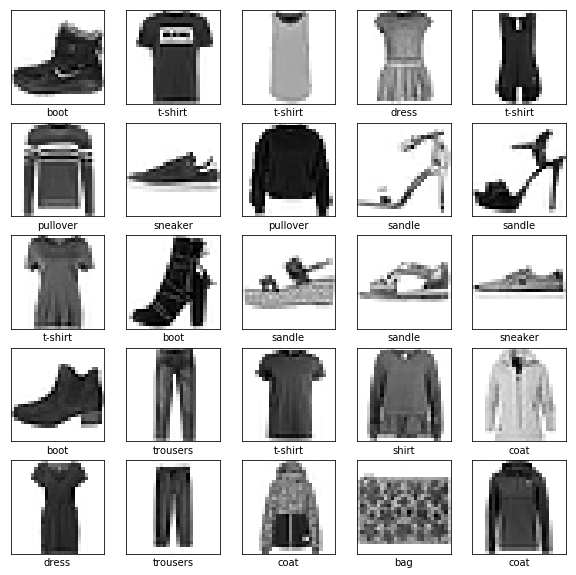

In [4]:
print("Images from the Training dataset")
showSampleImages(x_train, y_train, class_names)

The images are more complex because there are similarities between image of different classes - for example images of a Shirt and a Coat are similar but consistently different.

This makes it a more complex dataset to solve

# Data Pre-Processing
As before we will normalise the data so that each pixel has a value between 0 and 1 instead of 0 and 255. 

Again, this makes the images lighter but does not really change the relative difference between the pixels.

In [5]:
# Normalise the data
x_train = tf.keras.utils.normalize(x_train, axis=1)
x_test = tf.keras.utils.normalize(x_test, axis=1)

Normalised Images


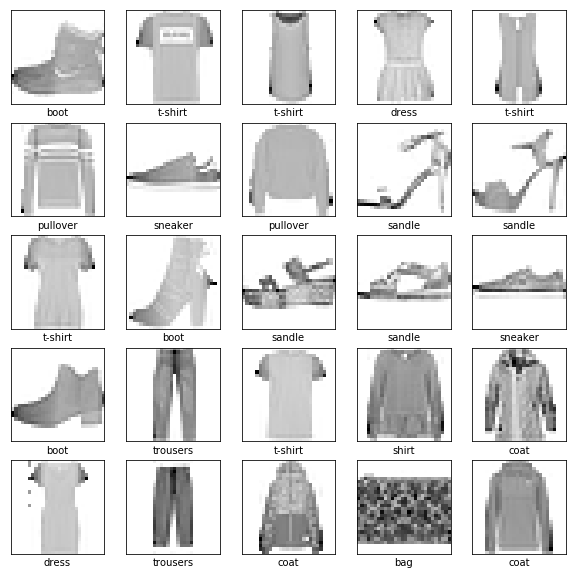

In [6]:
print("Normalised Images")
showSampleImages(x_train, y_train, class_names)

## Exercise
Discucss in your groups what you think _Human Level Performance_ would be for this task.

Which classifications do you think a human might get confused with?

## Exercise: Define your model
Discuss in your groups what models you want to try against this data. Think about the:
- Number of Hidden Layers in your model
- The number of nodes in each of you Hidden Layers
- How many epochs you will train for

How many nodes do you need in your Output Layer?

Come up with enough different models that you can each train a different model.

In [ ]:
model = tf.keras.models.Sequential()

# Input layer
# TODO: Specify the input shape
model.add(tf.keras.layers.Flatten(input_shape=(None, None)))

# YOUR CHANGES START HERE
# Hidden Layers
# TODO: Define your network architecture. 
# Remember that in keras we define new  layers using:
#   tf.keras.layers.Dense(units = 16, activation=tf.nn.relu)
# You need to decide how many layers and what side each layer should be
# Options include:
#    - copy this line to add additional layers
#    - Change the number of nodes (from 32) to some other value such as 64, 128 or 256
#    - Combine additional layers with different numbers of nodes
model.add(None)

# Output layer
# TODO: Define how many output nodes you need to classify the images (change None to the number of classes)
model.add(tf.keras.layers.Dense(units=None, activation=tf.nn.softmax))
# YOUR CHANGES END HERE

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

## Train your model
Decide how many epochs to train your model for and proceed to train your model

In [ ]:
# Train the model
# YOUR CHANGES START HERE
# TODO: Set the number of epochs to train for
num_epochs = None
# YOUR CHANGES END HERE
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(x_train, y_train, epochs=num_epochs, validation_split = 0.2, 
                    callbacks=[early_stop])

## Evaluate our model
Now that we have trained our model (and hopefully the Accuracy of the model is greater than 90%) we can evaluate our model on the _testing dataset_

In [ ]:
val_loss, val_acc = model.evaluate(x_test, y_test)
print ("Test Loss:", val_loss)
print ("Test Accuracy:", val_acc)

In [ ]:
# summarize history for loss and accuracty across epochs
displayLossAndAccuracy(history)

In [ ]:
# Produce the Confusion Matrix
test_predictions = model.predict_classes(x_test)
for i, label in enumerate(class_names):
    print("{} = {}".format(i, label))
displayConfusionMatrix(y_test, test_predictions)

In [ ]:
# Display some of the incorrectly classified images
printSampleIncorrectImages(x_test, y_test, class_names, model)

### Exercise
In groups, disucss the following:
- Which model performed best?
- Did your model generalise well to the unseen data?
    - Hint look at how close was your Testing Accuracy was to the Training Accuracy?
- Does your model appraoch Human Level Performance on this task?

# Summary
In this workbook you created a model to classify images of fashion items into 10 categories. While this task is similar to the hand-written digits our model did not perform as well. 

The main reason of this is the complexity of the image and the model architcutre we used. By flattening our images into a single row of data we loose some of the spacial relationships within the image. The spacial relationships still exist in the data but are harder to discover as they are in different features. This makes relationships between the features more complex to model...even for larger/deeper networks.

In the next workbook we will look at some specialised network layers that seek to preserve these relationships and provide a much better model.

The following are key observations to note before we move on
1. The relationship between local features can be important and so we need ways to capture this information to enable better learning.
2. Models can have good accuracy during training but don't generalise well - this is known as Overfitting.
3. The more complex the taks the more involved the network architecture can become.